# Evaluation

# Create SoilWaterDataset object 

SoilWaterDataset is a fundamental object created based on TabularDataset from the TSL library. Using this object, we will be able to enabling efficient loading, preprocessing, and spatiotemporal structuring of data.



In [1]:
from typing import Optional, Union, List
import numpy as np
import pandas as pd 

from tsl.datasets.prototypes import TabularDataset
from tsl.ops.similarities import gaussian_kernel

class SoilWaterDataset(TabularDataset):

    similarity_options = {'distance', 'grid'}

    def __init__(self,
                 root: str = None
                 ):

        self.root = root

        # Load data
        target, mask, u, dist, metadata = self.load()

        covariates = {
            'u': (u),
            'metadata' : (metadata),
            'distances': (dist)
        }

        super().__init__(target=target,
                         mask=mask,
                         covariates=covariates,
                         similarity_score='distance',
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         name='SoilWaterDataset')

    def load(self):
        """
        Load data from files.

        Returns:
            tuple: Containing target, mask, covariates, distances, and metadata.
        """
        target_path = f"{self.root}target.npy"
        mask_path = f"{self.root}mask.npy"
        dist_path = f"{self.root}distance_matrix.npy"
        covariates_path = f"{self.root}covariates.npy"
        metadata_path = f"{self.root}metadata.npy"

        target = np.load(target_path)
        mask = np.load(mask_path)
        u = np.load(covariates_path)
        dist = np.load(dist_path)
        metadata = np.load(metadata_path)

        return target, mask, u, dist, metadata


    def compute_similarity(self, method: str, **kwargs):
        """
        Compute similarity matrix based on the specified method.

        Args:
            method (str): The similarity computation method ('distance' or 'grid').
            **kwargs: Additional keyword arguments for similarity computation.

        Returns:
            numpy.ndarray: Computed similarity matrix.

        Raises:
            ValueError: If an unknown similarity method is provided.
        """
        if method == "distance":
            # Calculate a Gaussian kernel similarity from the distance matrix, using a default or provided 'theta'
            theta = kwargs.get('theta', np.std(self.distances))
            return gaussian_kernel(self.distances, theta=theta)
        elif method == "grid":
            dist = self.distances.copy()
            dist[dist > 16] = np.inf  # keep only grid edges
            theta = kwargs.get('theta', 20)
            return gaussian_kernel(dist, theta=theta)
        else:
            raise ValueError(f"Unknown similarity method: {method}")

In [2]:
dataset = SoilWaterDataset(root='ml-drought-forecasting/soil-water-forecasting/data/05_model_input/')

In [3]:
dataset.set_mask(dataset.mask)

# Create connectivity to our graph 

Here, we adjust the connectivity to retain only the five nearest neighbors (knn=5) per node, while excluding self-loops and normalizing along the specified axis.

In [4]:
import torch

connectivity = torch.load("ml-drought-forecasting/soil-water-forecasting/data/05_model_input/connectivity.pt")

/tmp/ipykernel_68554/2660955998.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  connectivity = torch.load("ml-drought-forecasting/soil-water-forecasting/data/05_model_in

# Create torch_dataset 

torch_dataset, created using SpatioTemporalDataset from the tsl library, structures time-series and spatial data (target, covariates, mask, and connectivity) into a form optimized for spatiotemporal model training, enabling easy handling of lookback windows and prediction horizons in forecasting tasks.


In [5]:
from tsl.data import SpatioTemporalDataset

covariates=dataset.covariates
mask = dataset.mask

torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      mask=mask,
                                      covariates=covariates,
                                      connectivity=connectivity,
                                      horizon=6, # Predict 7 step ahead
                                      window=12, # Use 30 timestamps to predict the next one
                                      stride=1 # Move 7 step forward each time
                                      )

# Create datamodule

datamodule, created with SpatioTemporalDataModule, manages the SpatioTemporalDataset by applying scaling, splitting data into train/validation/test sets, and preparing data loaders with batch processing, enabling efficient, modular, and scalable data handling for deep learning models.

In [6]:
from tsl.data.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'target': MinMaxScaler(axis=(0, 1)),
    'u': MinMaxScaler(axis=(0, 1))
}

In [7]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
                                 
# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.35, test_len=0.1)


In [8]:
# Create a SpatioTemporalDataModule
datamodule = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    mask_scaling=True,
    splitter=splitter,
    batch_size=1,  # Reduce batch size
    # workers=2,     # Reduce number of workers
    )

print(datamodule)

SpatioTemporalDataModule(train_len=None, val_len=None, test_len=None, scalers=[target, u], batch_size=1)


In [9]:
datamodule.setup()

# Create STGNN Model Architecture

The **TimeAndGraphAnisoModel** is built based on code from [HD-TTS
 repository](https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/time_and_graph_anisotropic.py) and the research paper by Cini et al. (2023d). This model utilizes spatiotemporal architectures equipped with anisotropic message passing for effective time and space representation.

### Reference
Cini, A., Marisca, I., Zambon, D., and Alippi, C. *Taming Local Effects in Graph-Based Spatiotemporal Forecasting.* In *Advances in Neural Information Processing Systems,* volume 36, pp. 55375–55393. Curran Associates, Inc., 2023.  
[https://arxiv.org/abs/2302.04071](https://arxiv.org/abs/2302.04071)


https://github.com/marshka/hdtts/blob/main/lib/nn/layers/anisotropic.py

In [10]:
from typing import Optional

import torch
from torch import nn, Tensor
from torch_geometric.nn import MessagePassing
from tsl.nn.blocks import RNNBase
from tsl.nn.layers import Dense, GraphGRUCellBase, Activation


class GraphAnisoConv(MessagePassing):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 1,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        super(GraphAnisoConv, self).__init__(aggr="add", node_dim=-2)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.msg_mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2 * (in_channels if i == 0 else out_channels),
                          out_channels),
                Activation(activation),
                nn.Linear(out_channels, out_channels),
            )
            for i in range(kernel_size)
        ])

        edge_dim = edge_dim or 1  # accommodate for edge_weight
        self.lin_edge = nn.Linear(edge_dim, out_channels, bias=False)

        self.gate_mlp = Dense(out_channels, 1, activation='sigmoid')

        self.skip_conn = nn.Linear(in_channels, out_channels)
        self.activation = Activation(activation)

    def forward(self, x, edge_index, edge_attr: Optional[Tensor] = None):
        """"""
        out, x_ = 0, x
        for idx in range(self.kernel_size):
            x_ = self.propagate(edge_index, idx=idx, x=x_, edge_attr=edge_attr)
            out += x_
        out = self.activation(out + self.skip_conn(x))
        return out

    def message(self, x_i, x_j, idx, edge_attr: Optional[Tensor] = None):
        mij = self.msg_mlps[idx](torch.cat([x_i, x_j], -1))
        if edge_attr is not None:
            if edge_attr.ndim == 1:  # accommodate for edge_weight
                edge_attr = edge_attr.view(-1, 1)
            mij = mij + self.lin_edge(edge_attr)
        return self.gate_mlp(mij) * mij


class GraphAnisoGRUCell(GraphGRUCellBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        # instantiate gates
        forget_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        update_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        candidate_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                        edge_dim=edge_dim,
                                        activation=activation)
        super(GraphAnisoGRUCell, self).__init__(hidden_size=hidden_size,
                                                forget_gate=forget_gate,
                                                update_gate=update_gate,
                                                candidate_gate=candidate_gate)


class GraphAnisoGRU(RNNBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 n_layers: int = 1, cat_states_layers: bool = False,
                 return_only_last_state: bool = False,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        rnn_cells = [
            GraphAnisoGRUCell(input_size if i == 0 else hidden_size,
                              hidden_size, edge_dim=edge_dim,
                              activation=activation)
            for i in range(n_layers)
        ]
        super(GraphAnisoGRU, self).__init__(rnn_cells, cat_states_layers,
                                            return_only_last_state)

https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/prototypes.py

In [11]:
from typing import Optional, Union, List

import torch
from torch import Tensor, nn
from torch_geometric.typing import Adj
from tsl.nn.blocks import MLPDecoder
from tsl.nn.layers import MultiLinear, NodeEmbedding
from tsl.nn.models import BaseModel
from tsl.nn.utils import maybe_cat_exog
from tsl.utils import ensure_list


def maybe_cat_emb(x: Tensor, emb: Optional[Tensor]):
    if emb is None:
        return x
    if emb.ndim < x.ndim:
        emb = emb[[None] * (x.ndim - emb.ndim)]
    emb = emb.expand(*x.shape[:-1], -1)
    return torch.cat([x, emb], dim=-1)


class STGNN(BaseModel):
    available_embedding_pos = {'encoding', 'decoding'}

    def __init__(self, input_size: int, horizon: int,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Optional[
                     Union[str, List[str]]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(STGNN, self).__init__()

        self.input_size = input_size
        self.horizon = horizon
        self.n_nodes = n_nodes
        self.output_size = output_size or input_size
        self.hidden_size = hidden_size
        self.exog_size = exog_size
        self.activation = activation

        # EMBEDDING
        if add_embedding_before is None:
            add_embedding_before = set()
        else:
            add_embedding_before = set(ensure_list(add_embedding_before))
            if not add_embedding_before.issubset(self.available_embedding_pos):
                raise ValueError("Parameter 'add_embedding_before' must be a "
                                 f"subset of {self.available_embedding_pos}")
        self.add_embedding_before = add_embedding_before

        if emb_size > 0:
            self.emb = NodeEmbedding(n_nodes, emb_size)
        else:
            self.register_module('emb', None)

        # ENCODER
        self.encoder_input = input_size + exog_size
        if 'encoding' in self.add_embedding_before and self.emb is not None:
            self.encoder_input += emb_size

        if use_local_weights is not None:
            self.use_local_weights = set(ensure_list(use_local_weights))
            if len(self.use_local_weights.difference(['encoder', 'decoder'])):
                raise ValueError("Parameter 'use_local_weights' must be "
                                 "'encoder', 'decoder', or both.")
        else:
            self.use_local_weights = set()

        if 'encoder' in self.use_local_weights:
            self.encoder = MultiLinear(self.encoder_input, hidden_size, n_nodes)
        else:
            self.encoder = nn.Linear(self.encoder_input, hidden_size)

        # DECODER
        self.decoder_input = hidden_size
        if 'decoding' in self.add_embedding_before and self.emb is not None:
            self.decoder_input += emb_size
        if 'decoder' in self.use_local_weights:
            raise NotImplementedError()
        else:
            self.decoder = MLPDecoder(input_size=self.decoder_input,
                                      hidden_size=self.hidden_size,
                                      output_size=self.output_size,
                                      horizon=self.horizon,
                                      activation=self.activation)

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        raise NotImplementedError

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: Optional[Tensor] = None,
                u: Optional[Tensor] = None,
                node_idx: Optional[Tensor] = None) -> Tensor:
        """"""
        # x: [batches steps nodes features]
        x = maybe_cat_exog(x, u)
        batch_size = x.size(0)
        emb = self.emb(expand=(batch_size, -1, -1),
                       node_index=node_idx) if self.emb is not None else None

        if 'encoding' in self.add_embedding_before and emb is not None:
            x = maybe_cat_emb(x, emb[:, None])

        # ENCODER   ###########################################################
        x = self.encoder(x)

        # SPATIOTEMPORAL MESSAGE-PASSING   ####################################
        out = self.stmp(x, edge_index, edge_weight, emb)

        # DECODER   ###########################################################
        if 'decoding' in self.add_embedding_before:
            out = maybe_cat_emb(out, emb)

        out = self.decoder(out)

        return out


class TimeAndSpace(STGNN):

    def __init__(self, input_size: int, horizon: int, stmp_conv: nn.Module,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(TimeAndSpace, self).__init__(input_size=input_size,
                                           horizon=horizon,
                                           n_nodes=n_nodes,
                                           output_size=output_size,
                                           exog_size=exog_size,
                                           hidden_size=hidden_size,
                                           emb_size=emb_size,
                                           add_embedding_before=add_embedding_before,
                                           use_local_weights=use_local_weights,
                                           activation=activation)

        # STMP
        self.stmp_conv = stmp_conv

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        # spatiotemporal encoding
        out = self.stmp_conv(x, edge_index, edge_weight)
        return out


https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/time_and_graph_anisotropic.py

In [12]:
from typing import Union, List

class TimeAndGraphAnisoModel(TimeAndSpace):

    def __init__(self, input_size: int, horizon: int, n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 n_layers: int = 1,
                 activation: str = 'elu'):
        stmp_conv = GraphAnisoGRU(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  n_layers=n_layers,
                                  activation=activation,
                                  return_only_last_state=True)
        super(TimeAndGraphAnisoModel, self).__init__(
            input_size=input_size,
            horizon=horizon,
            stmp_conv=stmp_conv,
            n_nodes=n_nodes,
            output_size=output_size,
            exog_size=exog_size,
            hidden_size=hidden_size,
            emb_size=emb_size,
            add_embedding_before=add_embedding_before,
            use_local_weights=use_local_weights,
            activation=activation
        )


# Setup model 

Model is configured with hidden units, feed-forward layers, multiple SpatioTemporalConvNet blocks, and utilizes temporal and spatial convolution kernels, layer normalization, and gated mechanisms; it adapts to the dataset’s input size, number of nodes, horizon, and available exogenous features.

In [13]:
hidden_size = 32          # Number of hidden units
ff_size = 64             # Number of units in the feed-forward layers
n_layers = 3              # Number of SpatioTemporalConvNet blocks
temporal_kernel_size = 3  # Size of the temporal convolution kernel
spatial_kernel_size = 3   # Order of the spatial diffusion process
norm='layer'
gated=True

input_size = torch_dataset.n_channels
n_nodes = torch_dataset.n_nodes
horizon = torch_dataset.horizon
exog_size = torch_dataset.input_map.u.shape[-1] if 'u' in torch_dataset else 0

In [14]:
model = TimeAndGraphAnisoModel(
    input_size=input_size,
    horizon=horizon,
    n_nodes=n_nodes,
    output_size=input_size,
    exog_size=exog_size,
    hidden_size=hidden_size
)

# Print the model architecture
print(model)

TimeAndGraphAnisoModel(
  (emb): None
  (encoder): Linear(in_features=23, out_features=32, bias=True)
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=32, bias=True)
          (activation): ELU(alpha=1.0)
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=32, out_features=6, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=6)
  )
  (stmp_conv): GraphAnisoGRU(cell=GraphAnisoGRUCell, return_only_last_state=True)
)


In [15]:
def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

In [16]:
print_model_size(model)

Number of model (TimeAndGraphAnisoModel) parameters:     24009


# Setup training 

This setup initializes a Predictor for the model with a masked mean-squared error loss function and multiple evaluation metrics (MSE, MAE, MAPE, and specific MSE at selected timesteps), then configures a Trainer using PyTorch Lightning with early stopping and model checkpointing based on validation MSE, gradient clipping to prevent exploding gradients, and 16-bit precision for efficient training.

In [17]:
from tsl.metrics.torch import MaskedMSE, MaskedMAE, MaskedMAPE
from tsl.engines import Predictor

# Define the loss function
loss_fn = MaskedMSE()

# Setup metrics
metrics = {
    'mse': MaskedMSE(),
    'mae': MaskedMAE(),
    'mape': MaskedMAPE(),
    'mse_at_3': MaskedMSE(at=2),  # '2' indicates the third time step
    'mse_at_6': MaskedMSE(at=5)
}

# Setup predictor
predictor = Predictor(
    model=model,
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)


https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='val_mse',
    patience=30,
    mode='min'
)

from pathlib import Path

# Logs 
dirpath = Path('ml-drought-forecasting/soil-water-forecasting/data/06_models/TimeAndGraphAniso/logs')

dirpath.mkdir(parents=True, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=dirpath,
    save_top_k=1,
    monitor='val_mse', 
    mode='min',
)

# Setup trainer
trainer = pl.Trainer(max_epochs=2,
                    #  logger=logger,
                    #  limit_train_batches=100,  # end an epoch after 200 updates
                     callbacks=[early_stop_callback, checkpoint_callback],
                     log_every_n_steps=2,
                     gradient_clip_val=1.0,    # Prevent exploding gradients
                     precision=16
                     )


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Training 

In [19]:
# Set float32 matmul precision to 'medium' or 'high'
torch.set_float32_matmul_precision('medium')

In [20]:
# import multiprocessing
# multiprocessing.set_start_method('spawn', force=True)
# trainer.fit(predictor, datamodule=datamodule)

# Evaluation

In [21]:
# Load only the state_dict (weights) safely
predictor.load_model('/teamspace/studios/this_studio/ml-drought-forecasting/soil-water-forecasting/data/06_models/TimeAndGraphAniso/logs/epoch=1-step=70.ckpt')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tsl/engines/predictor.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  storage = torch.load(filename,

In [22]:
predictor.freeze()

In [23]:
# Evaluate on the test set
trainer.test(predictor, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Arguments ['metadata', 'distances'] are filtered out. Only args ['x', 'edge_index', 'u'] are forwarded to the model (TimeAndGraphAnisoModel).


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.001270285458303988    │
│         test_mae          │   0.018240638077259064    │
│         test_mape         │      9354.2978515625      │
│         test_mse          │   0.001270285458303988    │
│       test_mse_at_3       │   0.0012959549203515053   │
│       test_mse_at_6       │   0.0013875284930691123   │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 0.018240638077259064,
  'test_mape': 9354.2978515625,
  'test_mse': 0.001270285458303988,
  'test_mse_at_3': 0.0012959549203515053,
  'test_mse_at_6': 0.0013875284930691123,
  'test_loss': 0.001270285458303988}]

In [24]:
# Evaluate on the validation set
trainer.validate(predictor, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.0011534555815160275   │
│          val_mae          │   0.017836544662714005    │
│         val_mape          │       12957.2109375       │
│          val_mse          │   0.0011534555815160275   │
│       val_mse_at_3        │   0.0011509435717016459   │
│       val_mse_at_6        │   0.0012453640811145306   │
└───────────────────────────┴───────────────────────────┘

[{'val_mae': 0.017836544662714005,
  'val_mape': 12957.2109375,
  'val_mse': 0.0011534555815160275,
  'val_mse_at_3': 0.0011509435717016459,
  'val_mse_at_6': 0.0012453640811145306,
  'val_loss': 0.0011534555815160275}]

# Predict

In [25]:
predictions_test = trainer.predict(predictor, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
predictions_test

[{'y': tensor([[[[ 2.9829e-01],
            [ 2.9829e-01],
            [ 2.9829e-01],
            ...,
            [-5.7735e-06],
            [-5.7735e-06],
            [-5.7735e-06]],
  
           [[ 2.9800e-01],
            [ 2.9800e-01],
            [ 2.9800e-01],
            ...,
            [ 4.2701e-07],
            [ 4.2701e-07],
            [ 4.2701e-07]],
  
           [[ 3.1431e-01],
            [ 3.1431e-01],
            [ 3.1431e-01],
            ...,
            [-9.6592e-06],
            [-9.6592e-06],
            [-9.6592e-06]],
  
           [[ 3.1568e-01],
            [ 3.1568e-01],
            [ 3.1568e-01],
            ...,
            [-5.9584e-06],
            [-5.9584e-06],
            [-5.9584e-06]],
  
           [[ 3.1438e-01],
            [ 3.1438e-01],
            [ 3.1438e-01],
            ...,
            [ 1.1064e-06],
            [ 1.1064e-06],
            [ 1.1064e-06]],
  
           [[ 3.1875e-01],
            [ 3.1875e-01],
            [ 3.1875e-01],

In [27]:
splitter.indices

{'train': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 'val': array([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 'test': array([72, 73, 74, 75, 76, 77, 78])}

In [28]:
import xarray as xr

# Load the dataset
ds = xr.open_dataset(
    'ml-drought-forecasting/soil-water-forecasting/data/04_feature/features.nc'
)

In [29]:
dates = pd.to_datetime(ds['date'].values)

In [30]:
import numpy as np
import pandas as pd
import torch
import xarray as xr

# 1. Load Metadata and Dates
metadata_array = np.load('ml-drought-forecasting/soil-water-forecasting/data/05_model_input/metadata.npy')  # Shape: (21960, 2)

In [31]:
latitudes = metadata_array[:, 0]
longitudes = metadata_array[:, 1]
num_nodes = len(latitudes)
total_time_steps = len(dates)

In [47]:
total_time_steps

96

In [32]:
# 2. Correctly Retrieve the Split Indices
split_indices = datamodule.splitter.indices
train_indices = split_indices['train']
val_indices = split_indices['val']
test_indices = split_indices['test']

In [44]:
train_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [46]:
test_indices

array([72, 73, 74, 75, 76, 77, 78])

In [45]:
val_indices

array([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [33]:
# Process Predictions and Actual Values
y_list = []
y_hat_list = []
mask_list = []

for batch in predictions_test:
    y_tensor = batch['y']
    y_hat_tensor = batch['y_hat']
    mask_tensor = batch['mask']
    
    y_np = y_tensor.cpu().numpy().squeeze(-1)      # Shape: (batch_size, steps, nodes)
    y_hat_np = y_hat_tensor.cpu().numpy().squeeze(-1)
    mask_np = mask_tensor.cpu().numpy().squeeze(-1)
    
    y_list.append(y_np)
    y_hat_list.append(y_hat_np)
    mask_list.append(mask_np)

In [48]:
y_list

[array([[[ 2.9828829e-01,  2.9828829e-01,  2.9828829e-01, ...,
          -5.7735015e-06, -5.7735015e-06, -5.7735015e-06],
         [ 2.9800457e-01,  2.9800457e-01,  2.9800457e-01, ...,
           4.2701140e-07,  4.2701140e-07,  4.2701140e-07],
         [ 3.1430614e-01,  3.1430614e-01,  3.1430614e-01, ...,
          -9.6592121e-06, -9.6592121e-06, -9.6592121e-06],
         [ 3.1568313e-01,  3.1568313e-01,  3.1568313e-01, ...,
          -5.9583690e-06, -5.9583690e-06, -5.9583690e-06],
         [ 3.1437793e-01,  3.1437793e-01,  3.1437793e-01, ...,
           1.1064112e-06,  1.1064112e-06,  1.1064112e-06],
         [ 3.1874663e-01,  3.1874663e-01,  3.1874663e-01, ...,
          -9.4743446e-06, -9.4743446e-06, -9.4743446e-06]]], dtype=float32),
 array([[[ 2.9800457e-01,  2.9800457e-01,  2.9800457e-01, ...,
           4.2701140e-07,  4.2701140e-07,  4.2701140e-07],
         [ 3.1430614e-01,  3.1430614e-01,  3.1430614e-01, ...,
          -9.6592121e-06, -9.6592121e-06, -9.6592121e-06],
      

In [49]:
y_hat_list


[array([[[ 0.23051214,  0.2895026 ,  0.28912804, ..., -0.00459087,
          -0.00462014,  0.01431914],
         [ 0.16908716,  0.28294808,  0.2827608 , ..., -0.00695079,
          -0.00689226, -0.0138769 ],
         [ 0.15981722,  0.29942796,  0.29924068, ...,  0.00590363,
           0.00592704,  0.10260585],
         [ 0.29025167,  0.2906262 ,  0.2906262 , ..., -0.00555503,
          -0.00556966,  0.01555981],
         [ 0.24624293,  0.27545723,  0.27526996, ..., -0.00487032,
          -0.00483813,  0.0131838 ],
         [-0.02310001,  0.3147842 ,  0.31459692, ...,  0.00260883,
           0.00257664,  0.05391531]]], dtype=float32),
 array([[[ 0.22863942,  0.29231164,  0.29156256, ..., -0.0062573 ,
          -0.00627193,  0.01019332],
         [ 0.16936806,  0.2868808 ,  0.2866935 , ..., -0.00913659,
          -0.00910148, -0.0146845 ],
         [ 0.1597236 ,  0.30729336,  0.3069188 , ...,  0.00628403,
           0.00632499,  0.10410402],
         [ 0.29100075,  0.29474616,  0.2941843

In [34]:
# Concatenate along the batch dimension
y = np.concatenate(y_list, axis=0)         # Shape: (num_test_batches, steps, nodes)
y_hat = np.concatenate(y_hat_list, axis=0) # Shape: (num_test_batches, steps, nodes)
mask = np.concatenate(mask_list, axis=0)   # Shape: (num_test_batches, steps, nodes)

In [50]:
y

array([[[ 2.9828829e-01,  2.9828829e-01,  2.9828829e-01, ...,
         -5.7735015e-06, -5.7735015e-06, -5.7735015e-06],
        [ 2.9800457e-01,  2.9800457e-01,  2.9800457e-01, ...,
          4.2701140e-07,  4.2701140e-07,  4.2701140e-07],
        [ 3.1430614e-01,  3.1430614e-01,  3.1430614e-01, ...,
         -9.6592121e-06, -9.6592121e-06, -9.6592121e-06],
        [ 3.1568313e-01,  3.1568313e-01,  3.1568313e-01, ...,
         -5.9583690e-06, -5.9583690e-06, -5.9583690e-06],
        [ 3.1437793e-01,  3.1437793e-01,  3.1437793e-01, ...,
          1.1064112e-06,  1.1064112e-06,  1.1064112e-06],
        [ 3.1874663e-01,  3.1874663e-01,  3.1874663e-01, ...,
         -9.4743446e-06, -9.4743446e-06, -9.4743446e-06]],

       [[ 2.9800457e-01,  2.9800457e-01,  2.9800457e-01, ...,
          4.2701140e-07,  4.2701140e-07,  4.2701140e-07],
        [ 3.1430614e-01,  3.1430614e-01,  3.1430614e-01, ...,
         -9.6592121e-06, -9.6592121e-06, -9.6592121e-06],
        [ 3.1568313e-01,  3.1568313e-0

In [51]:
y_hat

array([[[ 2.30512142e-01,  2.89502591e-01,  2.89128035e-01, ...,
         -4.59087454e-03, -4.62013576e-03,  1.43191367e-02],
        [ 1.69087157e-01,  2.82948077e-01,  2.82760799e-01, ...,
         -6.95078541e-03, -6.89226296e-03, -1.38768964e-02],
        [ 1.59817219e-01,  2.99427956e-01,  2.99240679e-01, ...,
          5.90363331e-03,  5.92704210e-03,  1.02605850e-01],
        [ 2.90251672e-01,  2.90626198e-01,  2.90626198e-01, ...,
         -5.55502903e-03, -5.56965917e-03,  1.55598093e-02],
        [ 2.46242926e-01,  2.75457233e-01,  2.75269955e-01, ...,
         -4.87031834e-03, -4.83813090e-03,  1.31838042e-02],
        [-2.31000073e-02,  3.14784199e-01,  3.14596921e-01, ...,
          2.60882871e-03,  2.57664174e-03,  5.39153069e-02]],

       [[ 2.28639424e-01,  2.92311639e-01,  2.91562557e-01, ...,
         -6.25729607e-03, -6.27192669e-03,  1.01933163e-02],
        [ 1.69368058e-01,  2.86880791e-01,  2.86693513e-01, ...,
         -9.13659297e-03, -9.10147838e-03, -1.46845

In [35]:
# Map Node IDs to Geographical Coordinates
num_steps = y.shape[1]          # Number of prediction steps (e.g., 6)
num_test_dates = y.shape[0]     # Number of test dates (e.g., 25)

# Create node_ids, lat, lon repeated for each step
node_ids = np.tile(np.arange(num_nodes), num_test_dates * num_steps)  # Shape: (3,294,000,)
lat_column = np.tile(latitudes, num_test_dates * num_steps)
lon_column = np.tile(longitudes, num_test_dates * num_steps)

In [36]:
# Align Predictions with Dates

# Repeat each test date for the number of prediction steps
test_dates_steps = np.repeat(dates[test_indices], num_steps)  # Shape: (25 * 6,) => (150,)

# Now, repeat each date for all nodes to align with the predictions
all_dates_expanded = np.repeat(test_dates_steps, num_nodes)   # Shape: (150 * 21960,) => (3,294,000,)

In [37]:
#  Flatten the Predictions and Mask
y_flat = y.flatten()         # Shape: (3,294,000,)
y_hat_flat = y_hat.flatten()
mask_flat = mask.flatten()

In [38]:
#  Apply Mask to Filter Valid Entries
valid_indices = mask_flat.astype(bool)  # Ensure mask is boolean

In [39]:
filtered_dates = all_dates_expanded[valid_indices]  # Shape: (num_valid_entries,)
filtered_lat = lat_column[valid_indices]
filtered_lon = lon_column[valid_indices]
filtered_y = y_flat[valid_indices]
filtered_y_hat = y_hat_flat[valid_indices]
filtered_node_ids = node_ids[valid_indices]

In [40]:
#  Create the DataFrame
df = pd.DataFrame({
    'date': filtered_dates,
    'lat': filtered_lat,
    'lon': filtered_lon,
    'node_id': filtered_node_ids,
    'y': filtered_y,
    'y_hat': filtered_y_hat
})

In [41]:
df 

date   lat    lon  node_id         y     y_hat
0       2022-01-01 -90.0    0.0        0  0.298288  0.230512
1       2022-01-01 -90.0    1.0        1  0.298288  0.289503
2       2022-01-01 -90.0    2.0        2  0.298288  0.289128
3       2022-01-01 -90.0    3.0        3  0.298288  0.289128
4       2022-01-01 -90.0    4.0        4  0.298288  0.289128
...            ...   ...    ...      ...       ...       ...
2736715 2022-07-01  90.0  355.0    65155 -0.000005 -0.002396
2736716 2022-07-01  90.0  356.0    65156 -0.000005 -0.002329
2736717 2022-07-01  90.0  357.0    65157 -0.000005 -0.002341
2736718 2022-07-01  90.0  358.0    65158 -0.000005 -0.002300
2736719 2022-07-01  90.0  359.0    65159 -0.000005  0.053494

[2736720 rows x 6 columns]

In [102]:
# df.to_parquet('ml-drought-forecasting/ml-modeling-pipeline/data/07_model_output/predictions.parquet')

# Visualization

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from typing import List, Optional
import pandas as pd
import numpy as np

def visualize_variables_on_map_matplotlib(
    dataset: pd.DataFrame,
    variables: List[str],  # ['y_hat', 'y']
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    projection: str = 'PlateCarree',
    color_scale: Optional[List] = None,
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
):

    df = dataset.dropna(subset=variables + [animation_frame] if animation_frame else variables)
    
    # Get min and max values for the variables to set consistent color scale
    data_values = df[variables].values.flatten()
    vmin = np.nanmin(data_values)
    vmax = np.nanmax(data_values)
    
    # Create the colormap
    if color_scale:
        positions = [x[0] for x in color_scale]
        colors = [x[1] for x in color_scale]
        rgb_colors = [to_rgb(color) for color in colors]
        colormap = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, rgb_colors)))
    else:
        colormap = plt.cm.viridis

    # Determine the projection
    if projection == 'PlateCarree':
        proj = ccrs.PlateCarree()
    elif projection == 'Mercator':
        proj = ccrs.Mercator()
    # Add other projections as needed
    else:
        proj = ccrs.PlateCarree()

    # If animation_frame is specified, loop over each date
    if animation_frame:
        dates = sorted(df[animation_frame].unique())
    else:
        dates = [None]  # Single frame

    for date in dates:
        if date is not None:
            df_date = df[df[animation_frame] == date]
            date_str = str(date)
        else:
            df_date = df
            date_str = ''
        
        fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(10*len(variables), 8), subplot_kw={'projection': proj})

        if len(variables) == 1:
            axes = [axes]  # Make it iterable

        for ax, variable in zip(axes, variables):
            ax.coastlines()
            sc = ax.scatter(
                df_date[lon_dim],
                df_date[lat_dim],
                c=df_date[variable],
                cmap=colormap,
                vmin=vmin,
                vmax=vmax,
                transform=ccrs.PlateCarree(),
            )
            ax.set_title(f"{variable} {date_str}")
            # Add colorbar
            cbar = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            cbar.set_label(variable)

        if title:
            fig.suptitle(title)

        plt.show()
        plt.close(fig)




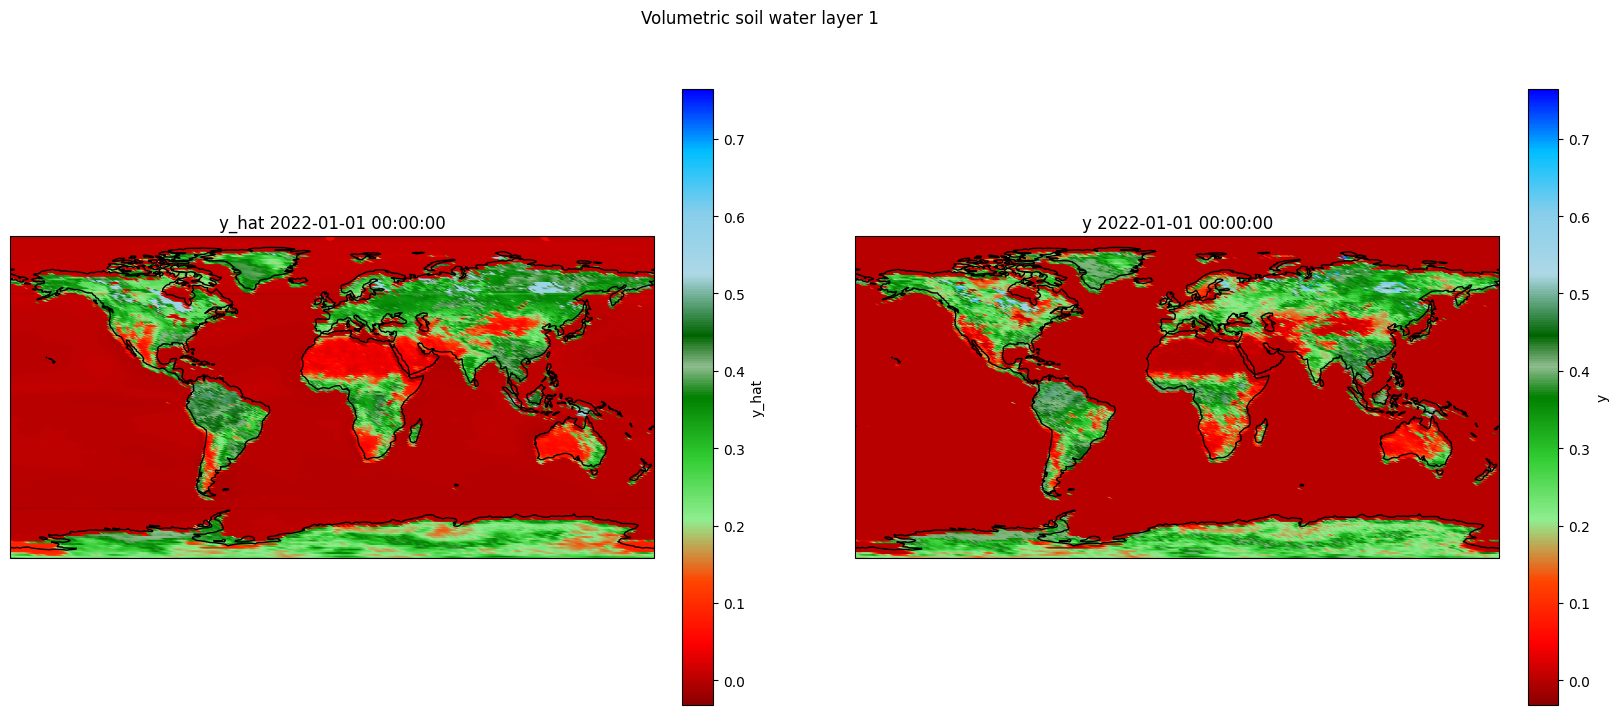

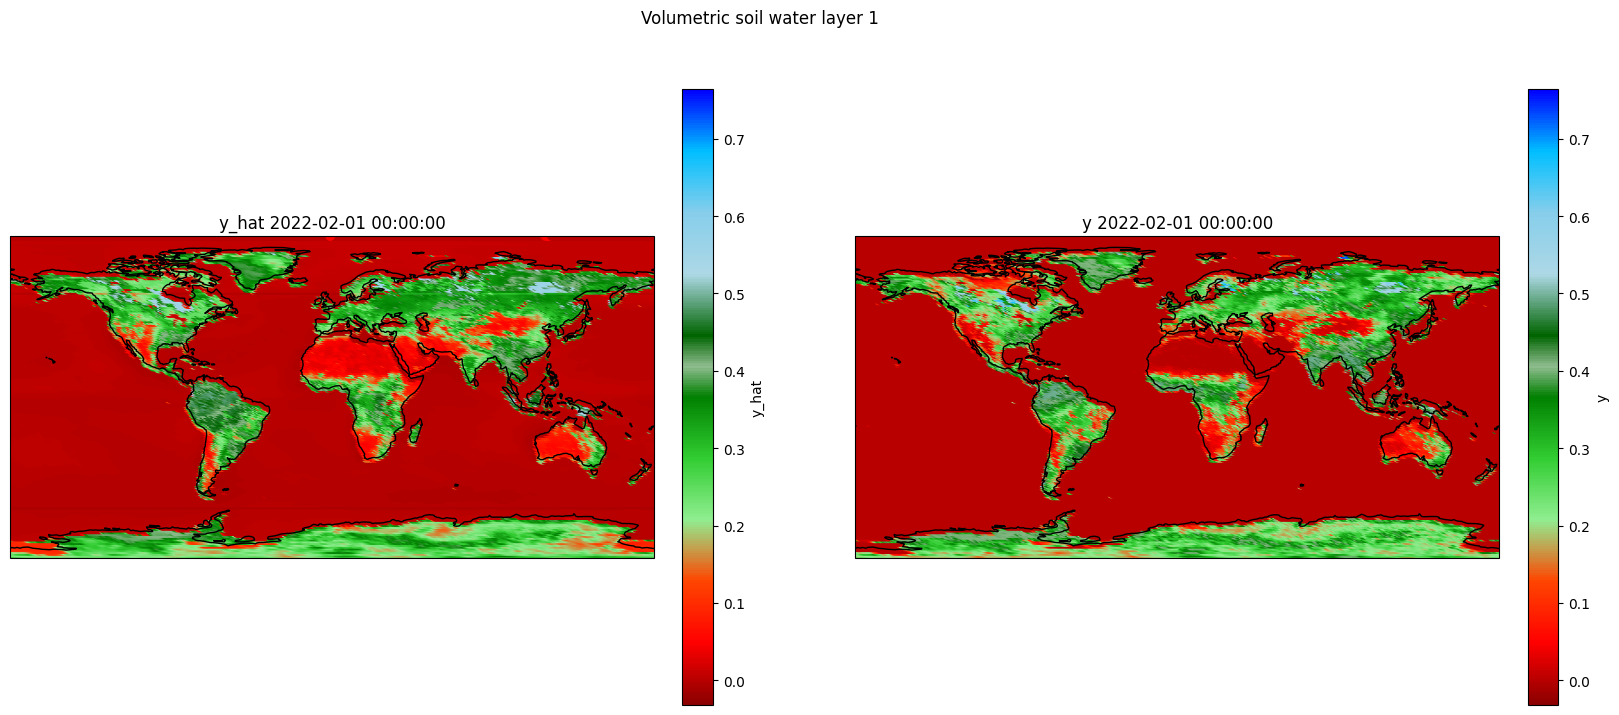

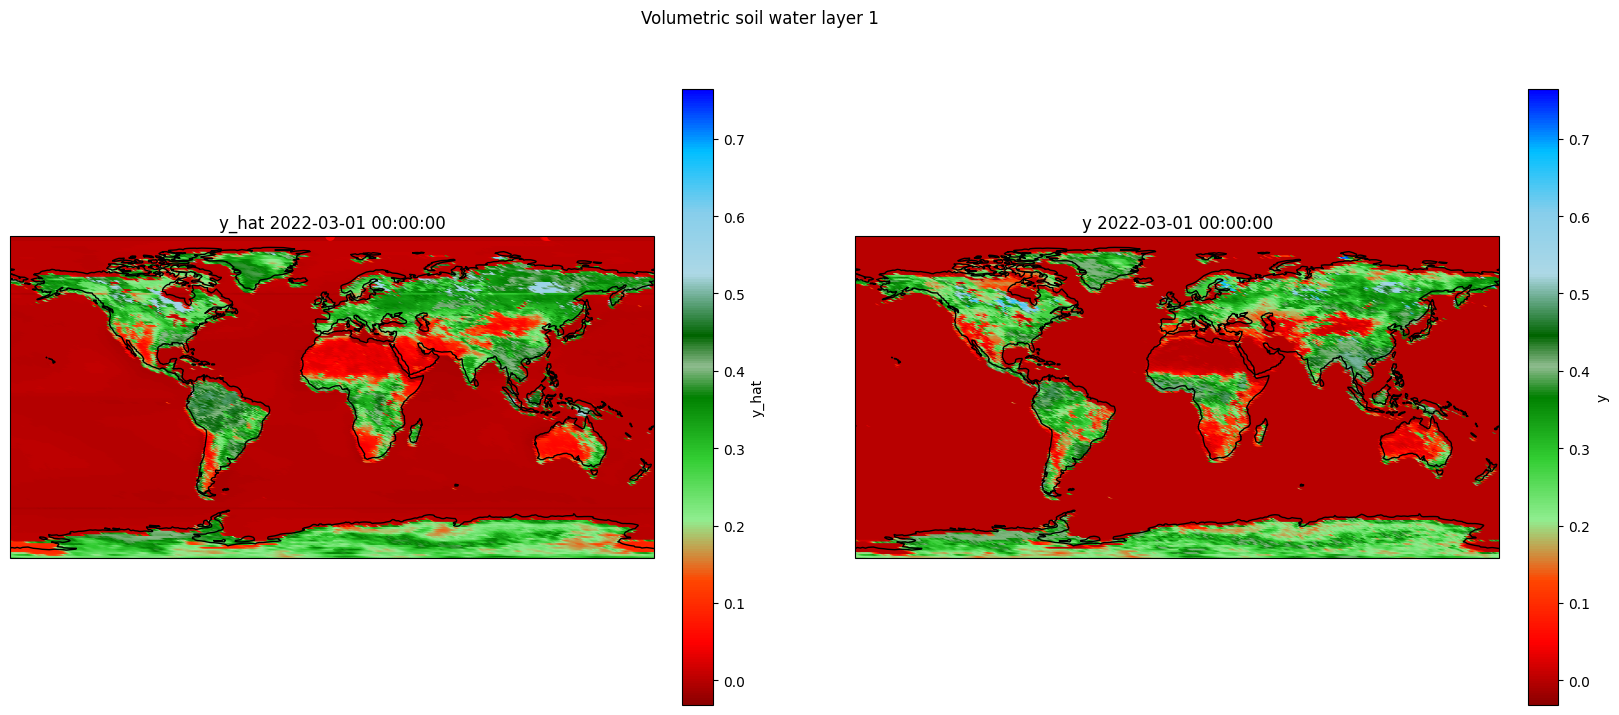

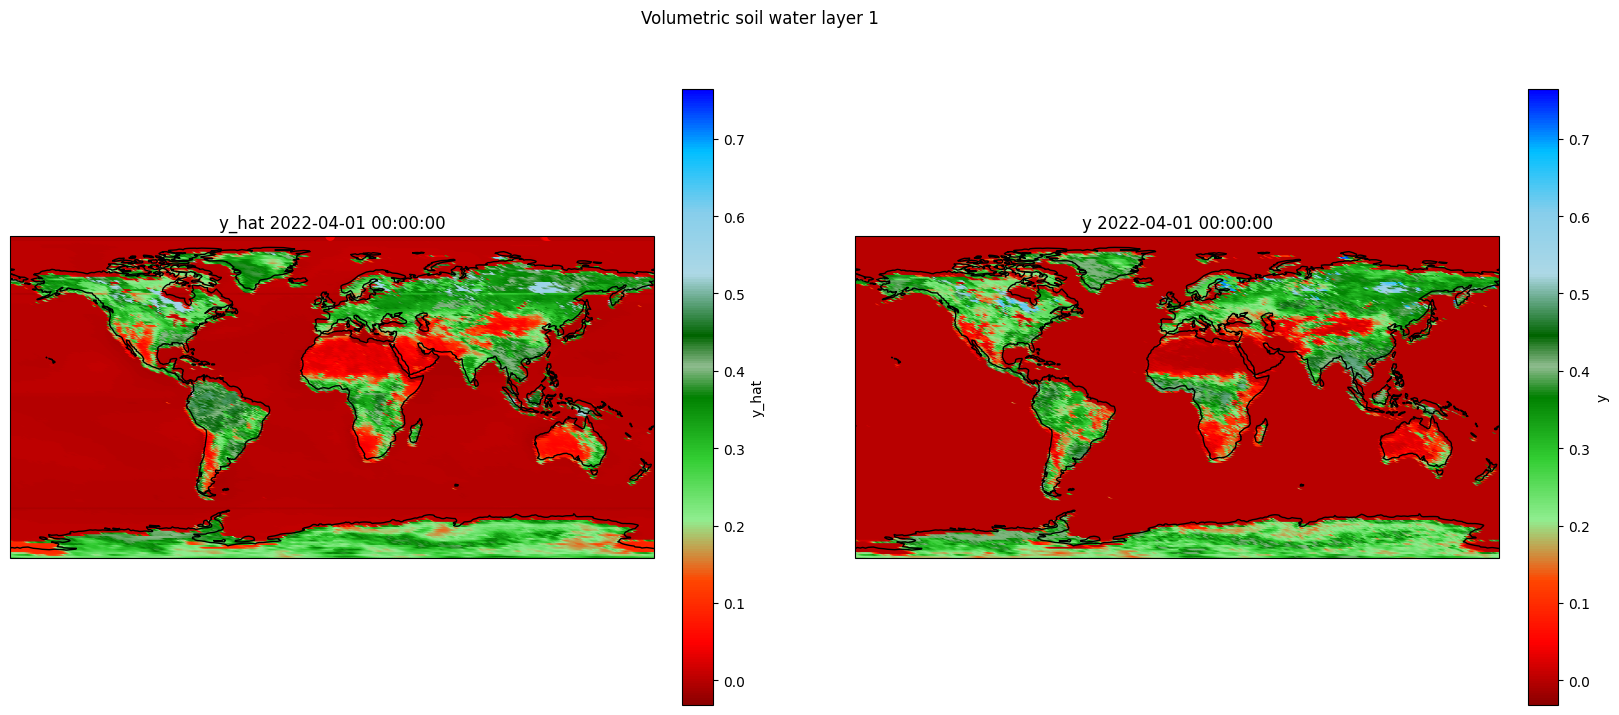

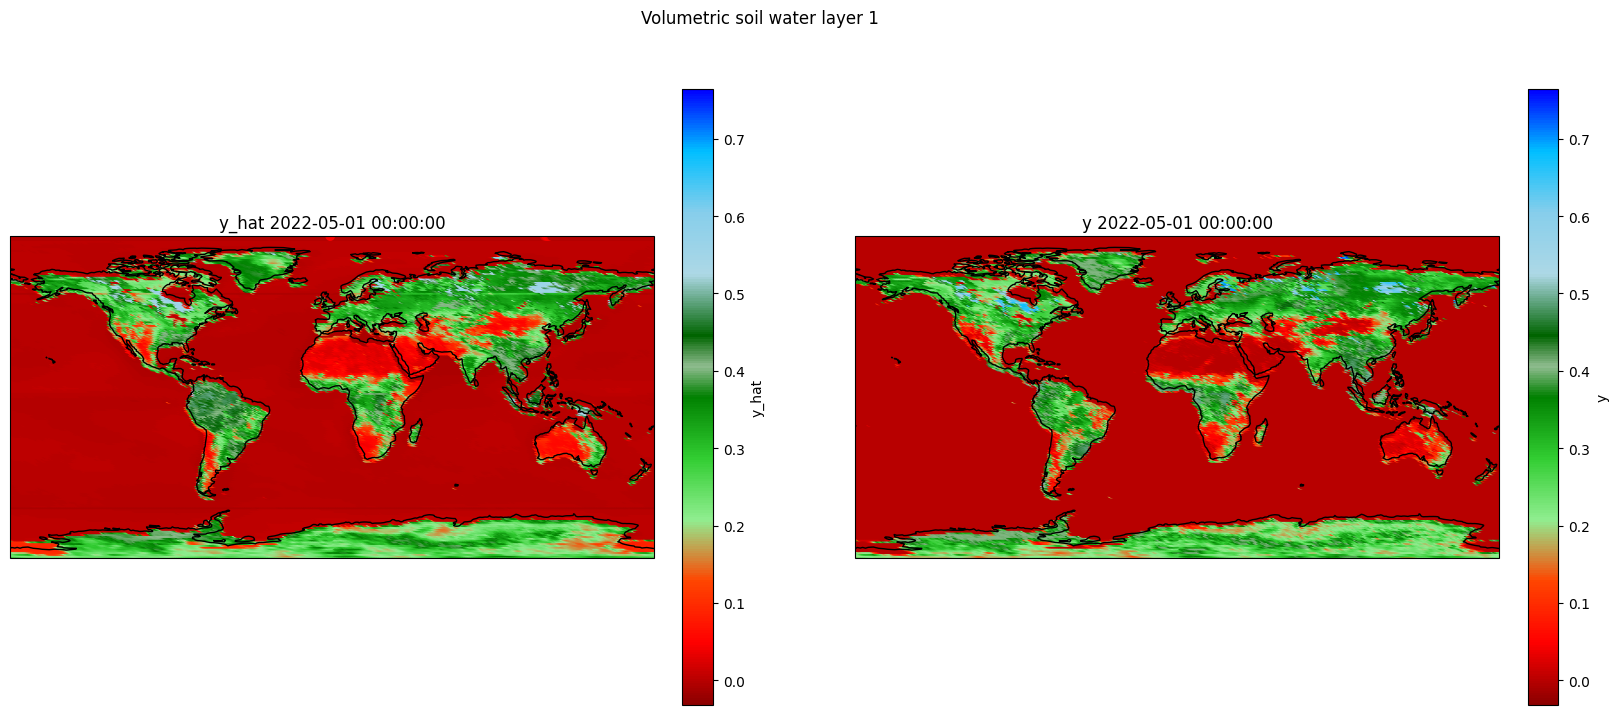

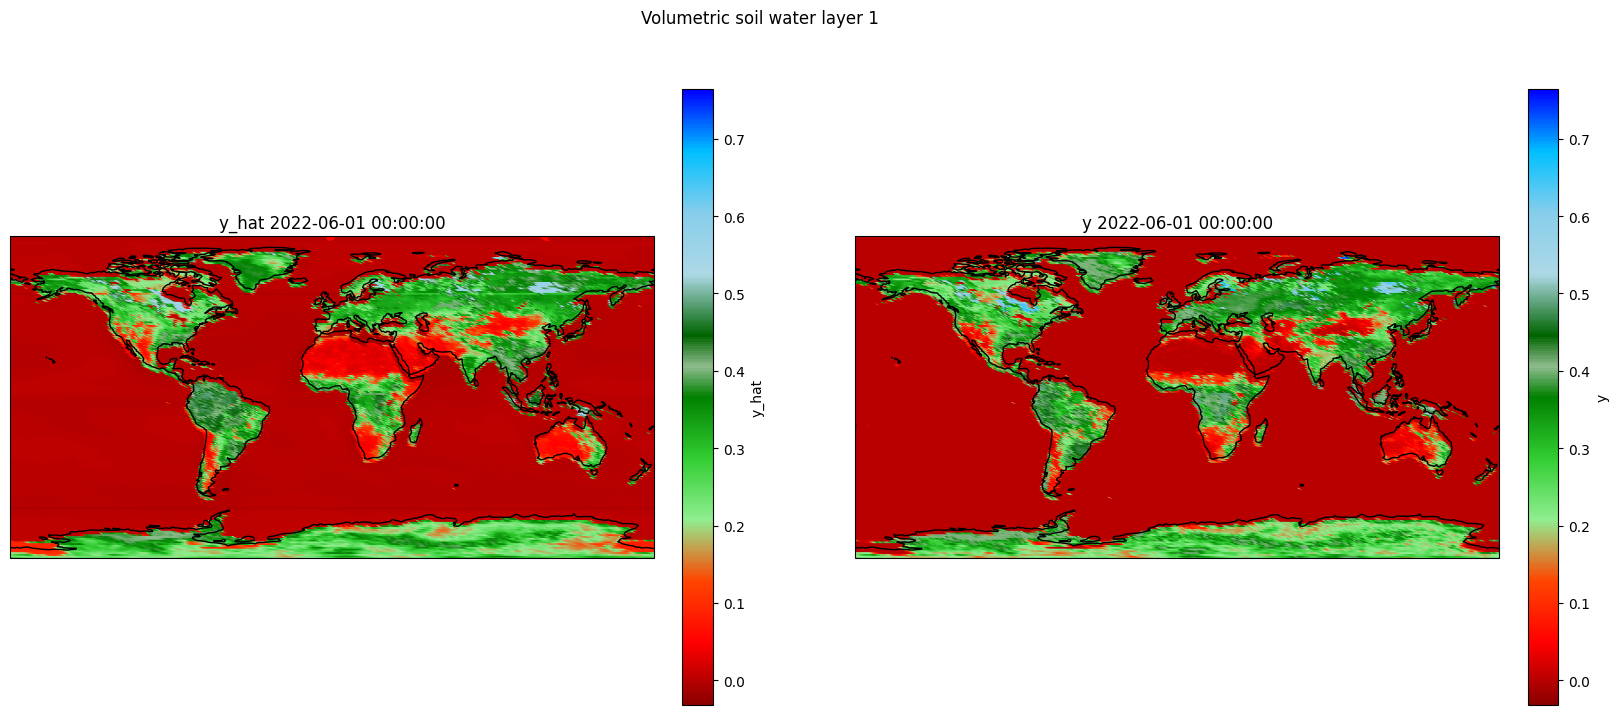

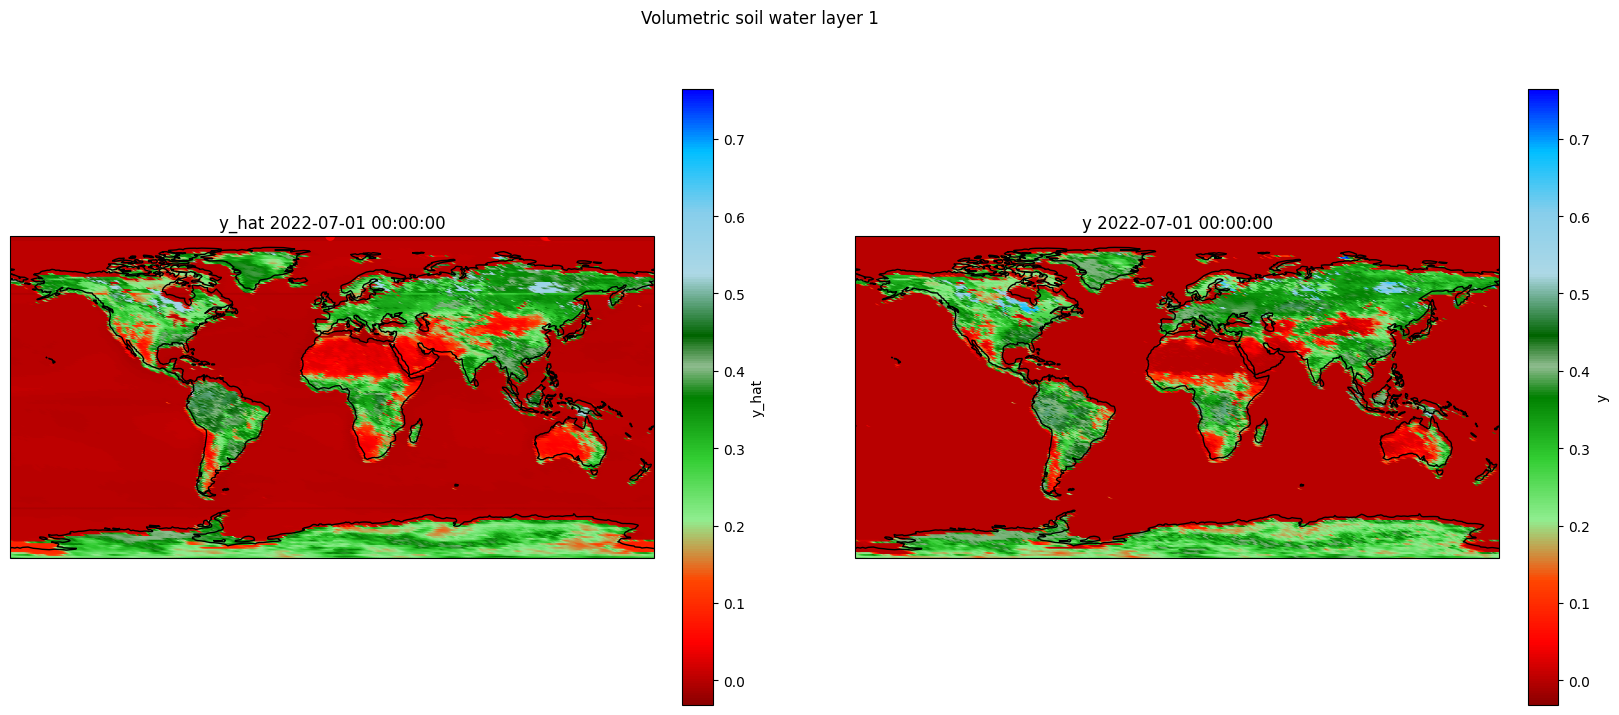

In [43]:
# Example usage:
# Assuming 'df' is your DataFrame with 'lat', 'lon', 'y', 'y_hat', and 'date' columns
visualize_variables_on_map_matplotlib(
    dataset=df,
    variables=['y_hat', 'y'],
    lat_dim='lat',
    lon_dim='lon',
    animation_frame='date',
    title='Volumetric soil water layer 1',
    color_scale = [
        [0.0, "darkred"],
        [0.1, "red"],
        [0.2, "orangered"],
        [0.3, "lightgreen"],
        [0.4, "limegreen"],
        [0.5, "green"],
        [0.55, "darkseagreen"],
        [0.6, "darkgreen"],
        [0.7, "lightblue"],
        [0.8, "skyblue"],
        [0.9, "deepskyblue"],
        [1.0, "blue"]
    ]
)

In [103]:
# from typing import Optional
# import plotly.express as px
# import plotly.graph_objects as go
# import pandas as pd

# def visualize_variable_on_map(
#     dataset: pd.DataFrame,
#     variable: str,
#     lat_dim: str = 'latitude',
#     lon_dim: str = 'longitude',
#     projection: str = 'natural earth',
#     color_scale: str = 'Viridis',
#     title: Optional[str] = None,
#     animation_frame: Optional[str] = None,
#     hover_precision: int = 2,
# ) -> go.Figure:

#     df = dataset

#     # Drop NaNs
#     df = df.dropna(subset=[variable])

#     # Handle animation frame
#     if animation_frame:
#         df[animation_frame] = df[animation_frame].astype(str)
#     else:
#         df['Frame'] = 'Frame'
    
#     # Create scatter_geo plot
#     fig = px.scatter_geo(
#         df,
#         lat=lat_dim,
#         lon=lon_dim,
#         color=variable,
#         animation_frame=animation_frame if animation_frame else 'Frame',
#         projection=projection,
#         color_continuous_scale=color_scale,
#         title=title,
#         labels={variable: variable.upper()},
#         hover_data={variable: f':.{hover_precision}f'},
#     )
    
#     # Add Play/Pause buttons
#     fig.update_layout(
#         updatemenus=[dict(
#             type='buttons',
#             buttons=[
#                 dict(label='Play',
#                      method='animate',
#                      args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
#                 dict(label='Pause',
#                      method='animate',
#                      args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
#             ],
#             showactive=False,
#             x=0.1,
#             y=0
#         )]
#     )

#     return fig

In [104]:
# # Example usage:
# fig = visualize_variable_on_map(
#     dataset=df,
#     variable='y',
#     lat_dim='lat',
#     lon_dim='lon',
#     animation_frame='date',
#     title='Volumetric soil water layer 1',
#     color_scale = [
#         [0.0, "darkred"],
#         [0.1, "red"],
#         [0.2, "orangered"],
#         [0.3, "lightgreen"],
#         [0.4, "limegreen"],
#         [0.5, "green"],
#         [0.55, "darkseagreen"],
#         [0.6, "darkgreen"],
#         [0.7, "lightblue"],
#         [0.8, "skyblue"],
#         [0.9, "deepskyblue"],
#         [1.0, "blue"]
#     ]
# )
# fig.show()

In [ ]:
# import plotly.graph_objects as go
# import plotly.subplots as sp
# import pandas as pd
# import numpy as np

# def visualize_predictions_plotly(predictions, metadata, idx, horizon=None, 
#                                  batches_to_visualize=None, variables_to_visualize=None):
#     """
#     Visualize predicted vs actual values using Plotly for specified batches and variables with variable-specific normalization.
    
#     Parameters:
#     - predictions (dict): Contains 'y' and 'y_hat' tensors.
#     - metadata (pd.DataFrame): DataFrame with 'lat' and 'lon' columns.
#     - idx (int): Index of the item being visualized.
#     - horizon (int, optional): Number of time steps to visualize. Defaults to the maximum horizon in data.
#     - batches_to_visualize (list or range, optional): List of batch indices to visualize. Defaults to all batches.
#     - variables_to_visualize (list or range, optional): List of variable indices to visualize. Defaults to all variables.
#     """
#     # Extract predictions and actual values
#     y_hat = predictions['y_hat'].squeeze().numpy()  # Shape: [batch, horizon, spatial_dim, variables]
#     y = predictions['y'].squeeze().numpy()          # Shape: [batch, horizon, spatial_dim, variables]

#     # Ensure y_hat and y have the same shape
#     assert y_hat.shape == y.shape, "Predictions and actual values must have the same shape"

#     # Determine the horizon if not provided
#     if horizon is None:
#         horizon = y_hat.shape[1]

#     # Determine the number of variables
#     if y_hat.ndim == 3:
#         # Shape: [batch, horizon, spatial_dim]
#         num_variables = 1
#         y_hat = y_hat[..., np.newaxis]  # Add a variables dimension
#         y = y[..., np.newaxis]
#     else:
#         num_variables = y_hat.shape[-1]

#     if variables_to_visualize is None:
#         variables_to_visualize = list(range(num_variables))
#     else:
#         # Ensure the variable indices are within the correct range
#         variables_to_visualize = [v for v in variables_to_visualize if v < num_variables]
#         if not variables_to_visualize:
#             raise ValueError("No valid variables to visualize. Check 'variables_to_visualize' indices.")

#     # Get latitude and longitude from metadata
#     lats = metadata['lat'].values
#     lons = metadata['lon'].values

#     # Ensure that the number of spatial points matches the number of lats and lons
#     spatial_dim = y_hat.shape[2]
#     if spatial_dim != len(lats):
#         raise ValueError(f"The number of spatial points in predictions ({spatial_dim}) does not match the number of locations in metadata ({len(lats)}).")

#     # Calculate the min and max for lats and lons for setting map extent
#     lat_min, lat_max = lats.min(), lats.max()
#     lon_min, lon_max = lons.min(), lons.max()

#     # If batches_to_visualize is None, visualize all batches
#     if batches_to_visualize is None:
#         batches_to_visualize = range(y_hat.shape[0])
#     else:
#         # Ensure the batch indices are within the correct range
#         batches_to_visualize = [b for b in batches_to_visualize if b < y_hat.shape[0]]
#         if not batches_to_visualize:
#             raise ValueError("No valid batches to visualize. Check 'batches_to_visualize' indices.")

#     # Precompute min and max for each variable in variables_to_visualize
#     var_min_max = {}
#     for var in variables_to_visualize:
#         var_data_y = y[..., var]  # Shape: [batch, horizon, spatial_dim]
#         var_data_y_hat = y_hat[..., var]  # Shape: [batch, horizon, spatial_dim]
#         min_val = min(np.min(var_data_y), np.min(var_data_y_hat))
#         max_val = max(np.max(var_data_y), np.max(var_data_y_hat))
#         import numpy as np

#         # ...

#         # Loop through each batch and variable
#         for batch in batches_to_visualize:
#             for var in variables_to_visualize:
#                 frames = []
#                 slider_steps = []

#                 # Retrieve normalization for the current variable
#                 min_val, max_val = var_min_max[var]

#                 # Get the highest and lowest values of the variable
#                 var_min = np.min(y_hat[batch, :, :, var])
#                 var_max = np.max(y_hat[batch, :, :, var])

#                 # Update the min and max values if necessary
#                 if var_min < min_val:
#                     min_val = var_min
#                 if var_max > max_val:
#                     max_val = var_max

#                 # Update the normalization dictionary
#                 var_min_max[var] = (min_val, max_val)

#                 # ...

#                 # Predicted data for current month
#                 pred_data = go.Scattergeo(
#                     lon=lons,
#                     lat=lats,
#                     mode='markers',
#                     marker=dict(
#                         size=6,
#                         color=y_hat[batch, time_step, :, var],
#                         colorscale='RdYlBu_r',
#                         cmin=min_val,
#                         cmax=max_val,
#                         colorbar=dict(title='Predicted'),
#                         opacity=0.8
#                     ),
#                     name='Predicted',
#                     showlegend=False
#                 )

#                 # Actual data for current month
#                 actual_data = go.Scattergeo(
#                     lon=lons,
#                     lat=lats,
#                     mode='markers',
#                     marker=dict(
#                         size=6,
#                         color=y[batch, time_step, :, var],
#                         colorscale='RdYlBu_r',
#                         cmin=min_val,
#                         cmax=max_val,
#                         colorbar=dict(title='Actual'),
#                         opacity=0.8
#                     ),
#                     name='Actual',
#                     showlegend=False
#                 )

#                 # ...

#                 # Initial data (first frame)
#                 pred_data_initial = go.Scattergeo(
#                     lon=lons,
#                     lat=lats,
#                     mode='markers',
#                     marker=dict(
#                         size=6,
#                         color=y_hat[batch, 0, :, var],
#                         colorscale='RdYlBu_r',
#                         cmin=min_val,
#                         cmax=max_val,
#                         colorbar=dict(title='Predicted'),
#                         opacity=0.8
#                     ),
#                     name='Predicted',
#                     showlegend=True
#                 )

#                 actual_data_initial = go.Scattergeo(
#                     lon=lons,
#                     lat=lats,
#                     mode='markers',
#                     marker=dict(
#                         size=6,
#                         color=y[batch, 0, :, var],
#                         colorscale='RdYlBu_r',
#                         cmin=min_val,
#                         cmax=max_val,
#                         colorbar=dict(title='Actual'),
#                         opacity=0.8
#                     ),
#                     name='Actual',
#                     showlegend=True
#                 )

#                 # ...
#                         visible=True,
#                         prefix="Date: ",
#                         xanchor="right",
#                         font=dict(size=14, color="#666")
#                     ),
#                 )],
#                 geo=dict(
#                     scope='world',
#                     projection_type='natural earth',
#                     showland=True,
#                     landcolor='lightgray',
#                     showcountries=True,
#                     countrycolor='black',
#                     lataxis=dict(range=[lat_min - 1, lat_max + 1]),
#                     lonaxis=dict(range=[lon_min - 1, lon_max + 1]),
#                 ),
#                 geo2=dict(
#                     scope='world',
#                     projection_type='natural earth',
#                     showland=True,
#                     landcolor='lightgray',
#                     showcountries=True,
#                     countrycolor='black',
#                     lataxis=dict(range=[lat_min - 1, lat_max + 1]),
#                     lonaxis=dict(range=[lon_min - 1, lon_max + 1]),
#                 )
#             )

#             # Update frames to assign traces to correct subplots
#             for frame in fig.frames:
#                 time_step_idx = int(frame.name.split()[1]) - 1
#                 frame.data = [
#                     go.Scattergeo(
#                         lon=lons,
#                         lat=lats,
#                         mode='markers',
#                         marker=dict(
#                             size=6,
#                             color=y_hat[batch, time_step_idx, :, var],
#                             colorscale='RdYlBu_r',
#                             cmin=min_val,
#                             cmax=max_val,
#                             opacity=0.8
#                         ),
#                         showlegend=False
#                     ),
#                     go.Scattergeo(
#                         lon=lons,
#                         lat=lats,
#                         mode='markers',
#                         marker=dict(
#                             size=6,
#                             color=y[batch, time_step_idx, :, var],
#                             colorscale='RdYlBu_r',
#                             cmin=min_val,
#                             cmax=max_val,
#                             opacity=0.8
#                         ),
#                         showlegend=False
#                     )
#                 ]

#             # Update layout for better appearance
#             fig.update_layout(
#                 height=600,
#                 width=1200,
#                 margin=dict(l=50, r=50, t=100, b=50)
#             )

#             # Display the figure
#             fig.show()

#             # Optionally, save the figure to an HTML file
#             # fig.write_html(f'item_{idx+1}_batch_{batch+1}_variable_{var+1}.html')

# # Example Usage

# # Assuming you have the metadata DataFrame available
# # metadata = pd.read_parquet('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/metadata.parquet')

# # Ensure that predictions_test is a list of dictionaries with 'y' and 'y_hat'
# # For example:
# # predictions_test = [{'y': tensor1, 'y_hat': tensor2}, {'y': tensor3, 'y_hat': tensor4}, ...]

# # # Specify the indices of the items you want to visualize
# # items_to_visualize = [1]  # Replace with desired item indices (0-based indexing)
# # batches_to_visualize = [0, 1]  # Replace with desired batch indices within each item
# # variables_to_visualize = [0]  # Replace with desired variable indices (e.g., if multiple EDDI metrics)

# # # Call the function for specified items in predictions_test
# # for idx in items_to_visualize:
# #     pred = predictions_test[idx]
# #     visualize_predictions_plotly(
# #         pred, metadata, idx, horizon=pred['y'].shape[1],
# #         batches_to_visualize=batches_to_visualize, 
# #         variables_to_visualize=variables_to_visualize
# #     )
# #     print(f"Processed item {idx + 1}/{len(predictions_test)}")
